####The goal of this project is to create an algorithm that can predict the winner of Formula One races.

We have utilized the official Formula 1 website which provides data on all championships and races from 1950 to 2019 for this analysis. We then integrated all of the race data, results, driver and constructor standings, qualifiers, and weather data into a single dataframe to use in this modeling.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Import the required libraries
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression  
from pyspark.ml.classification import RandomForestClassifier
  
from pyspark.ml.stat import Correlation       

from pyspark.ml.feature import OneHotEncoder

from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt 
from pyspark.sql.functions import desc
from pyspark.sql.functions import max
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Bucketizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
file_location = "/FileStore/tables/F1.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

## Computing data statistics for the F1 data set...

## Total Number of Seasons

In [0]:
df.select('season').distinct().count()

Out[293]: 37

## Total Number of Races

In [0]:
df.count() ##Since each record is a race result

Out[294]: 14273

d ## Total Number of Drivers

In [0]:
df.select('driver').distinct().count()

Out[295]: 226

## Number of Race Wins by Each Driver (Most Wins First)

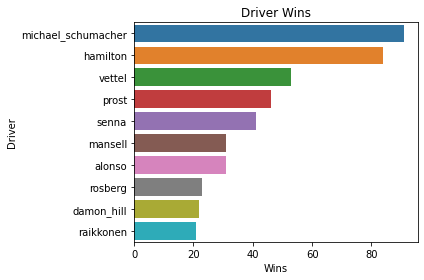

In [0]:
df1_agg = spark.sql("select driver as Driver,count(result) as Wins from (select driver,case when podium == '1' then 'win' else 'lose' end as result from f1)f1 where result = 'win' group by driver order by count(result) desc")
df1_agg=df1_agg.sort(desc('Wins')).limit(10)
pd_df1 = df1_agg.toPandas()  
g=sns.barplot(x='Wins',y='Driver',data=pd_df1)
g.set_title('Driver Wins')
plt.tight_layout()
plt.show()

###### The race results data set has been obtained from the Formula 1 archives and will be used to visualize race related statistics during our analysis.
###### However, the F1.csv will be used to model race win predictions.

In [0]:
file_location = "/FileStore/tables/race_results.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

results = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

###### Number of incidents per location

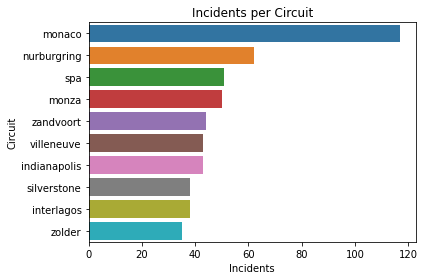

In [0]:
df1_agg = spark.sql("select circuit_id as Circuit, count(status) as Incidents from race_results where status = 'Accident' group by circuit_id order by count(status) desc")
df1_agg=df1_agg.sort(desc('Incidents')).limit(10)
pd_df1 = df1_agg.toPandas()  
g=sns.barplot(x='Incidents',y='Circuit',data=pd_df1)
g.set_title('Incidents per Circuit')
plt.tight_layout()
plt.show()

###### Cars with the most failures

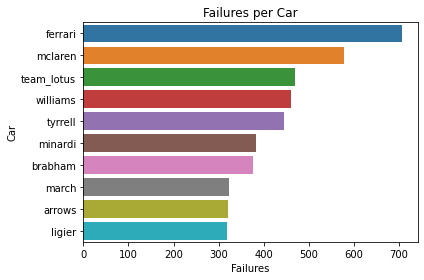

In [0]:
df1_agg = spark.sql("select constructor as Car, count(status) as Failures from race_results where status not like '+%' and status <> 'Finished' group by constructor order by count(status) desc")
df1_agg=df1_agg.sort(desc('Failures')).limit(10)
pd_df1 = df1_agg.toPandas()  
g=sns.barplot(x='Failures',y='Car',data=pd_df1)
g.set_title('Failures per Car')
plt.tight_layout()
plt.show()

###### Drivers with the most failures in the recent times

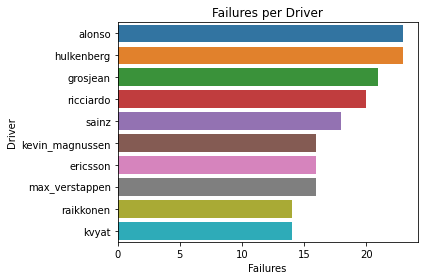

In [0]:
df1_agg = spark.sql("select driver as Driver, count(status) as Failures from race_results where status not like '+%' and status <> 'Finished' and cast(season as int) > 2015 group by driver order by count(status) desc")
df1_agg=df1_agg.sort(desc('Failures')).limit(10)
pd_df1 = df1_agg.toPandas()  
g=sns.barplot(x='Failures',y='Driver',data=pd_df1)
g.set_title('Failures per Driver')
plt.tight_layout()
plt.show()

In [0]:
df.cache()
df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- round: integer (nullable = true)
 |-- weather_warm: boolean (nullable = true)
 |-- weather_cold: boolean (nullable = true)
 |-- weather_dry: boolean (nullable = true)
 |-- weather_wet: boolean (nullable = true)
 |-- weather_cloudy: boolean (nullable = true)
 |-- driver: string (nullable = true)
 |-- grid: integer (nullable = true)
 |-- podium: integer (nullable = true)
 |-- driver_points: integer (nullable = true)
 |-- driver_wins: integer (nullable = true)
 |-- driver_standings_pos: integer (nullable = true)
 |-- constructor_points: integer (nullable = true)
 |-- constructor_wins: integer (nullable = true)
 |-- constructor_standings_pos: integer (nullable = true)
 |-- qualifying_time: double (nullable = true)
 |-- driver_age: integer (nullable = true)
 |-- circuit_id_BAK: integer (nullable = true)
 |-- circuit_id_adelaide: integer (nullable = true)
 |-- circuit_id_albert_park: integer (nullable = true)
 |-- circuit_id_americas: integer 

In [0]:
df.count()

df = df.dropna(how="any")
df.count()

Out[302]: 14273

In [0]:
from pyspark.sql.functions import when
df = df.withColumn("podium", when(df.podium == 1,1) \
      .otherwise(0))
df.show()

+------+-----+------------+------------+-----------+-----------+--------------+------------+----+------+-------------+-----------+--------------------+------------------+----------------+-------------------------+-------------------+----------+--------------+-------------------+----------------------+-------------------+------------------+-----------------------+--------------------+------------------+------------------+-----------------+-------------------------+----------------------+----------------+-----------------------+---------------------+-------------------+----------------------+----------------+------------------+----------------------+---------------------+-----------------+----------------+----------------------+-------------------------+------------------+------------------------+-----------------+--------------------+-----------------+-------------------+----------------------+----------------+--------------+-----------------+-------------------+---------------------+--

## Correlation Matrix

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
[[1.0, 0.14969372796932082, -0.1458470636273369, -0.23001292155770556, 0.02010417693005022], [0.14969372796932082, 1.0, -0.017406794110765286, 0.0026597032838580554, 0.0021487867580314824], [-0.1458470636273369, -0.017406794110765286, 1.0, -0.10212304379724901, -0.303093361712362], [-0.23001292155770556, 0.0026597032838580554, -0.10212304379724901, 1.0, 0.05812804288395668], [0.02010417693005022, 0.0021487867580314824, -0.303093361712362, 0.05812804288395668, 1.0]]
+--------------------+--------------------+--------------------+--------------------+--------------------+
|              season|               round|                grid|          driver_age|              podium|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0| 0.14969372796932082| -0.14584706

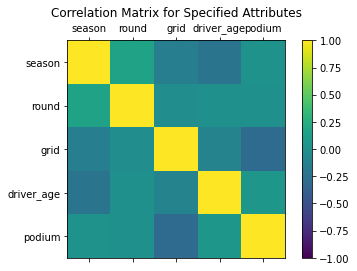

In [0]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

columns = ['season', 'round', 'grid', 'driver_age', 'podium']

myGraph=df
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=['season', 'round', 'grid', 'driver_age', 'podium'], 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(myGraph).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

corrdf = spark.createDataFrame(corrmatrix,columns)
corrdf.show()

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns, 234)



## Building the Logistic Regression Model

In [0]:
#Dropping columns based on the Correlation Matrix output...

df = df.drop(*['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy', 'driver_points', 'driver_wins', 'driver_standings_pos', 'constructor_points', 'constructor_wins', 'constructor_standings_pos', 'qualifying_time', 'circuit_id_BAK', 'circuit_id_adelaide', 'circuit_id_albert_park', 'circuit_id_americas', 'circuit_id_bahrain', 'circuit_id_brands_hatch', 'circuit_id_catalunya', 'circuit_id_detroit', 'circuit_id_estoril', 'circuit_id_galvez', 'circuit_id_hockenheimring', 'circuit_id_hungaroring', 'circuit_id_imola', 'circuit_id_indianapolis', 'circuit_id_interlagos', 'circuit_id_istanbul', 'circuit_id_jacarepagua', 'circuit_id_jerez', 'circuit_id_kyalami', 'circuit_id_magny_cours', 'circuit_id_marina_bay', 'circuit_id_monaco', 'circuit_id_monza', 'circuit_id_nurburgring', 'circuit_id_osterreichring', 'circuit_id_phoenix', 'circuit_id_red_bull_ring', 'circuit_id_ricard', 'circuit_id_rodriguez', 'circuit_id_sepang', 'circuit_id_shanghai', 'circuit_id_silverstone', 'circuit_id_sochi', 'circuit_id_spa', 'circuit_id_suzuka', 'circuit_id_valencia', 'circuit_id_villeneuve', 'circuit_id_yas_marina', 'circuit_id_yeongam', 'circuit_id_zandvoort', 'nationality_American', 'nationality_Australian', 'nationality_Austrian', 'nationality_Belgian', 'nationality_Brazilian', 'nationality_British', 'nationality_Canadian', 'nationality_Dutch', 'nationality_Finnish', 'nationality_French', 'nationality_German', 'nationality_Italian', 'nationality_Japanese', 'nationality_Mexican', 'nationality_Russian', 'nationality_Spanish', 'nationality_Swedish', 'constructor_arrows', 'constructor_bar', 'constructor_benetton', 'constructor_brabham', 'constructor_ferrari', 'constructor_footwork', 'constructor_force_india', 'constructor_haas', 'constructor_jaguar', 'constructor_jordan', 'constructor_larrousse', 'constructor_ligier', 'constructor_lotus_f1', 'constructor_mclaren', 'constructor_mercedes', 'constructor_minardi', 'constructor_prost', 'constructor_red_bull', 'constructor_renault', 'constructor_sauber', 'constructor_team_lotus', 'constructor_toro_rosso', 'constructor_toyota', 'constructor_tyrrell', 'constructor_williams'])

train_data_lr,test_data_lr=df.randomSplit([0.7,0.3])


driver_indexer_lr = StringIndexer(inputCol='driver',outputCol='driver_index_lr',handleInvalid='keep')


# Vector assembler is used to create a vector of input features

assembler_lr=VectorAssembler(inputCols=['driver_index_lr','season', 'round', 'grid', 'driver_age'],
                            outputCol="features")

# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data

pipe = Pipeline(stages=[driver_indexer_lr,assembler_lr])

fitted_pipe_lr=pipe.fit(train_data_lr)

train_data_lr=fitted_pipe_lr.transform(train_data_lr)

# Create an object for the Linear Regression model

lr_model = LogisticRegression(labelCol='podium')

# Fit the model on the train data

fit_model_lr = lr_model.fit(train_data_lr.select(['features','podium']))

# Transform the test data using the model to predict the duration

test_data_lr=fitted_pipe_lr.transform(test_data_lr)

# Store the results in a dataframe

results_lr = fit_model_lr.transform(test_data_lr)

results_lr.select(['podium','prediction','rawPrediction', 'prediction', 'probability']).show()

+------+----------+--------------------+----------+--------------------+
|podium|prediction|       rawPrediction|prediction|         probability|
+------+----------+--------------------+----------+--------------------+
|     0|       0.0|[6.54436519593175...|       0.0|[0.99856386867341...|
|     0|       0.0|[8.43987165722378...|       0.0|[0.99978396879902...|
|     0|       0.0|[6.97392837948534...|       0.0|[0.99906490638488...|
|     0|       0.0|[12.6345364337454...|       0.0|[0.99999674246469...|
|     0|       0.0|[15.5798660724604...|       0.0|[0.99999982870288...|
|     0|       0.0|[12.5450595006908...|       0.0|[0.99999643755361...|
|     0|       0.0|[3.07880565350611...|       0.0|[0.95600998383490...|
|     0|       0.0|[4.18566797589443...|       0.0|[0.98501589751486...|
|     0|       0.0|[1.33624290418410...|       0.0|[0.79187140942282...|
|     0|       0.0|[16.9055707373194...|       0.0|[0.99999995450078...|
|     0|       0.0|[9.16222921101054...|       0.0|

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="podium", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(results_lr)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9379921931762154
Test Error = 0.062007806823784595


### Random Forest Classifier

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train_data_rf,test_data_rf=df.randomSplit([0.7,0.3])


driver_indexer_rf = StringIndexer(inputCol='driver',outputCol='driver_index_rf',handleInvalid='keep')


# Vector assembler is used to create a vector of input features

assembler_rf=VectorAssembler(inputCols=['driver_index_rf','season', 'round', 'grid', 'driver_age'],
                            outputCol="features")

# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data

pipe = Pipeline(stages=[driver_indexer_rf,assembler_rf])

fitted_pipe_rf=pipe.fit(train_data_rf)

train_data_rf=fitted_pipe_rf.transform(train_data_rf)

# Create an object for the Linear Regression model
rf_model = RandomForestClassifier(labelCol="podium", featuresCol='features', numTrees=10, maxBins=226)

# Fit the model on the train data

fit_model_rf = rf_model.fit(train_data_rf)

# Transform the test data using the model to predict the duration

test_data_rf=fitted_pipe_rf.transform(test_data_rf)

# Store the results in a dataframe
fit_model_rf
results_rf = fit_model_rf.transform(test_data_rf)

results_rf.select(['podium','prediction','rawPrediction', 'prediction', 'probability']).show()

+------+----------+--------------------+----------+--------------------+
|podium|prediction|       rawPrediction|prediction|         probability|
+------+----------+--------------------+----------+--------------------+
|     0|       0.0|[9.93054543241223...|       0.0|[0.99305454324122...|
|     0|       0.0|[9.93054543241223...|       0.0|[0.99305454324122...|
|     0|       0.0|[9.93054543241223...|       0.0|[0.99305454324122...|
|     0|       0.0|[9.45492978886654...|       0.0|[0.94549297888665...|
|     0|       0.0|[6.52224644152598...|       0.0|[0.65222464415259...|
|     0|       0.0|[9.93430599146884...|       0.0|[0.99343059914688...|
|     0|       0.0|[9.93430599146884...|       0.0|[0.99343059914688...|
|     0|       0.0|[8.58759694139271...|       0.0|[0.85875969413927...|
|     0|       0.0|[9.79866281620030...|       0.0|[0.97986628162003...|
|     0|       0.0|[8.97980808675709...|       0.0|[0.89798080867570...|
|     0|       0.0|[9.93430599146884...|       0.0|

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="podium", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(results_rf)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.935991748511372
Test Error = 0.06400825148862799


### SVM Classifier

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train_data_sv,test_data_sv=df.randomSplit([0.7,0.3])

# String Indexer maps a string column of labels to ML column of labels

driver_indexer_sv = StringIndexer(inputCol='driver',outputCol='driver_index_sv',handleInvalid='keep')


# Vector assembler is used to create a vector of input features

assembler_sv=VectorAssembler(inputCols=['driver_index_sv','season', 'round', 'grid', 'driver_age'],
                            outputCol="features")

# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data

pipe = Pipeline(stages=[driver_indexer_sv,assembler_sv])

fitted_pipe_sv=pipe.fit(train_data_sv)

train_data_sv=fitted_pipe_sv.transform(train_data_sv)

# Create an object for the Linear Regression model
sv_model = LinearSVC(labelCol="podium", featuresCol='features', maxIter=100,regParam=0.1)

# Fit the model on the train data

fit_model_sv = sv_model.fit(train_data_sv)

# Transform the test data using the model to predict the duration

test_data_sv=fitted_pipe_sv.transform(test_data_sv)

# Store the results in a dataframe
fit_model_sv
results_sv = fit_model_sv.transform(test_data_sv)

results_sv.select(['podium','prediction','rawPrediction', 'prediction']).show()

+------+----------+--------------------+----------+
|podium|prediction|       rawPrediction|prediction|
+------+----------+--------------------+----------+
|     0|       0.0|[1.01392262190323...|       0.0|
|     0|       0.0|[1.01298964924521...|       0.0|
|     0|       0.0|[1.00071430442601...|       0.0|
|     0|       0.0|[1.01845898341138...|       0.0|
|     0|       0.0|[1.01025356957416...|       0.0|
|     0|       0.0|[1.02052536805386...|       0.0|
|     0|       0.0|[1.02517170179312...|       0.0|
|     0|       0.0|[1.00377803898135...|       0.0|
|     0|       0.0|[1.02189481612729...|       0.0|
|     0|       0.0|[1.01355413925893...|       0.0|
|     0|       0.0|[1.01465109758353...|       0.0|
|     0|       0.0|[1.00272912191116...|       0.0|
|     0|       0.0|[1.02434499764663...|       0.0|
|     0|       0.0|[1.02567181455198...|       0.0|
|     0|       0.0|[1.01146995916729...|       0.0|
|     0|       0.0|[1.03092898316493...|       0.0|
|     0|    

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="podium", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(results_sv)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.921095846112634
Test Error = 0.07890415388736605


### Multilayer Perceptron Classifier

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

train_data_ml,test_data_ml=df.randomSplit([0.7,0.3], 1234)

# String Indexer maps a string column of labels to ML column of labels

driver_indexer_ml = StringIndexer(inputCol='driver',outputCol='driver_index_ml',handleInvalid='keep')


# Vector assembler is used to create a vector of input features

assembler_ml=VectorAssembler(inputCols=['driver_index_ml','season', 'round', 'grid', 'driver_age'],
                            outputCol="features")

# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data

pipe = Pipeline(stages=[driver_indexer_ml,assembler_ml])

fitted_pipe_ml=pipe.fit(train_data_ml)

train_data_ml=fitted_pipe_ml.transform(train_data_ml)

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [5, 4, 3, 2]

# Create an object for the Linear Regression model
ml_model = MultilayerPerceptronClassifier(labelCol="podium", featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=1234)

# Fit the model on the train data

fit_model_ml = ml_model.fit(train_data_ml)

# Transform the test data using the model to predict the duration

test_data_ml=fitted_pipe_ml.transform(test_data_ml)

# Store the results in a dataframe
fit_model_ml
results_ml = fit_model_ml.transform(test_data_ml)

results_ml.select(['podium','prediction','rawPrediction', 'prediction', 'probability']).show()

+------+----------+--------------------+----------+--------------------+
|podium|prediction|       rawPrediction|prediction|         probability|
+------+----------+--------------------+----------+--------------------+
|     0|       0.0|[2.62514370270586...|       0.0|[0.99556646507187...|
|     0|       0.0|[2.62617838729502...|       0.0|[0.99557469688514...|
|     0|       0.0|[2.62624760277891...|       0.0|[0.99557524701166...|
|     0|       0.0|[2.62624794724305...|       0.0|[0.99557524974930...|
|     0|       0.0|[2.27962023235935...|       0.0|[0.99176471034834...|
|     0|       0.0|[2.62624630154996...|       0.0|[0.99557523667009...|
|     0|       0.0|[2.56789078760006...|       0.0|[0.99508643269498...|
|     0|       0.0|[2.43304473052088...|       0.0|[0.99374206306495...|
|     0|       0.0|[2.62624794284446...|       0.0|[0.99557524971435...|
|     0|       0.0|[2.62624745570694...|       0.0|[0.99557524584280...|
|     0|       0.0|[2.62624753842088...|       0.0|

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="podium", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(results_ml)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9412996538369253
Test Error = 0.058700346163074735


##Conclusions
1) The correlation matrix suggests that the chances of Race wins are affected by the Initial Grid position the most (corr = 0.30). 
2) Due to the high unpredictability of Formula 1, The race wins are often affected by factors like Car Failure and overtakes despite a #1 grid position towards the beginning of the race.

3) With the amount of accuracy we have achieved, we can use past data as Training set and predit the odds for F1 2023. 

4) Our additional Race_Results Data set suggests us that drivers always use home grounds to their advantage.

####Model Results:
1) Logistic Regression Model:
  Accuracy = 0.9314497919684289
  Test Error = 0.06855020803157108
2) Random Forest Classifier
  Accuracy = 0.9343509722956754
  Test Error = 0.06564902770432457
3) SVM Classifier
  Accuracy = 0.9279422326956283
  Test Error = 0.07205776730437174
4) Multilayer Perceptron Classifier
  Accuracy = 0.9412996538369253
  Test Error = 0.058700346163074735


#### The Multilayer Perceptron Classifier performs the best with 94% accuracy in predicting the race winner.